# Using the Trainer feature

Chainer has a feature called `Trainer` that can often be used to simplify the process of training and evaluating a model. This feature supports training a model in a way such that the user is not required to explicitly write the code for the training loop. For many types of models, including our MNIST model, `Trainer` allows us to write our training and evaluation code much more concisely.

Chainer contains several extensions that can be used with `Trainer` to visualize your results, evaluate your model, store and manage log files more easily.

This example will show how to use the `Trainer` feature to train a fully-connected feed-forward neural network on the MNIST dataset.

In [1]:
# Install Chainer and CuPy!

!curl https://colab.chainer.org/install | sh -

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


## 1. Prepare the dataset

Load the MNIST dataset, as in the previous notebook.

In [2]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


## 2. Prepare the dataset iterators

In [0]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

## 3. Prepare the Model

We use the same model as before. 

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, n_mid_units)
            self.l2=L.Linear(None, n_mid_units)
            self.l3=L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # Set to -1 if you don't have a GPU

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

## 4. Prepare the Updater

As mentioned above, the trainer object (instance of `Trainer`) actually implements the training loop for us. However, before we can use it, we must first prepare another object that will actually perform one iteration of training operations and pass it to the trainer. This other object will be an subclass of `Updater` such as `StandardUpdater` or a custom subclass. It will therefore need to hold all of the components that are needed in order to perform one iteration of training, such as a dataset iterator, and optimizer that also holds the model.

- Updater
    - Iterator
        - Dataset
    - Optimizer
        - Model

Since we can also write customized updaters, they can perform any kinds of computations. However, for this example we will use the `StandardUpdater` which performs the following steps each time it is called:

1. Retrieve a batch of data from a dataset using the iterator that we supplied.
2. Feed the batch into the model and calculate the loss using the optimizer that we supplied. Since we will supply the model to the optimizer first, this means that the updater can also access the model from the optimizer.
3. Update the model parameters using the optimizer that we supplied.

Once the updater has been set up, we can pass it to the trainer and start the training process. The trainer will then automatically create the training loop and call the updater once per iteration.

Now let's create the updater object.

In [0]:
from chainer import optimizers
from chainer import training

max_epoch = 10

# Note: L.Classifier is actually a chain that wraps 'model' to add a loss
# function.
# Since we do not specify a loss funciton here, the default 
# 'softmax_cross_entropy' is used.
# The output of this modified 'model' will now be a loss value instead
# of a class label prediction.
model = L.Classifier(model)

# Send the model to the GPU.
if gpu_id >= 0:
    model.to_gpu(gpu_id)

# selection of your optimizing method
optimizer = optimizers.SGD()
# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an Updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

### NOTE

The `L.Classifier` object is actually a chain that places our `model` in its `predictor` attribute. This modifies `model` so that when it is called, it will now take both the input image batch and a class label batch as inputs to its `__call__` method and output a `Variable` that contains the loss value. The loss function to use can be optionally set but we use the default which is `softmax_cross_entropy`.

Specifically, when `__call__` is called on our model (which is now a `L.Classifier` object), the image batch is supplied to its `predictor` attribute, which contains our `MLP` model. The ourput of the `MLP` (which consists of class label predictions) is supplied to the loss function along with the target class labels to compute the loss value which is then returned as a `Variable` object.

Note that we use `StandardUpdater`, which is the simplest type of `Updater` in Chainer. There are also other types of updaters available, such as `ParallelUpdater` (which is intended for multiple GPUs) and you can also write a custom updater if you wish.

## 5. Setup Trainer

Now that we have set up an updater, we can pass it to a `Trainer` object. You can optionally pass a `stop_trigger` to the second trainer argument as a tuple, `(length, unit)` to tell the trainer stop automatically according to your indicated timing. The `length` is given as an arbitrary integer and `unit` is given as a string which currently must be either `epoch` or `iteration`. Without setting `stop_trigger`, the training will not stop automatically.

In [0]:
# Send Updater to Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'),
                           out='mnist_result')

The `out` argument in the trainer will set up an output directory to save the logfiles, the image files of graphs to show the time progress of loss, accuracy, etc. 

Next, we will explain how to display/save those outputs by using `extensions`. 

## 6. Add extensions to trainer

There are several optional trainer `extensions` that provide the following capabilites: 

- Save log files automatically (`LogReport`)
- Display the training information to the terminal periodically (`PrintReport`)
- Visualize the loss progress by plottig a graph periodically and save its image (`PlotReport`)
- Automatically serialize the model or the state of Optimizer periodically (`snapshot`/`snapshot_object`)
- Display Progress Bar to show the progress of training (`ProgressBar`)
- Save the model architecture as a dot format readable by `Graphviz` (`dump_graph`)

Now you can utilize the wide variety of tools shown above right away! To do so, simply pass the desired `extensions` object to the `Trainer` object by using the `extend()` method of `Trainer`.

In [0]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.dump_graph('main/loss'))

### `LogReport`

Collect `loss` and `accuracy` automatically every `epoch` or `iteration` and store the information under the `log` file in the directory assigned by the `out` argument of `Trainer`.

### `PrintReport`

`Reporter` aggregates the results to output to the standard output. The timing for displaying the output can be given by the list. 

### `PlotReport`

`PlotReport` plots the values specified by its arguments, draws the graph and saves the image in the directory set by 'file name'.

### `snapshot`

The `snapshot` method saves the `Trainer` object at the designated timing (defaut: every epoch) in the directory assigned by `out` argument in `Trainer`. The `Trainer` object, as mentioned before, has an `Updater` which contains an `Optimizer` and a model inside. Therefore, as long as you have the snapshot file, you can use it to come back to the training or make inferences using the previously trained model later. 

### `snapshot_object`

When you save the whole `Trainer` object, in some cases it is very tedious to retrieve only the inside of the model. By using `snapshot_object`, you can save the particular object (in this case, the model wrapped by `Classifier`) in addition to saving the `Trainer` object. `Classifier` is a `Chain` object that keeps the `Chain` object given by the first argument as a property called `predictor` and calculates the loss. `Classifier` doesn't have any parameters other than those inside its predictor model, and so we only save `model.predictor`. 

### `Evaluator`

The `Iterator` that uses the evaluation dataset (such as a validation or test dataset) and the model object are passed to `Evaluator`. The `Evaluator` evaluates the model using the given dataset at the specified timing interval. 

### `dump_graph`

This method saves the computational graph of the model. The graph is saved in `Graphviz` dot format. The output location (directory) to save the graph is set by the `out` argument of `Trainer`. 

---

The `extensions` class has a lot of options other than those mentioned here. For instance, by using the `trigger` option, you can set individual timings to activate the `extensions` more flexibly. Please take a look at the official document in more detail：[Trainer extensions](http://docs.chainer.org/en/latest/reference/extensions.html)

## 7. Start Training

To start training, just call `run` method from `Trainer` object.

In [8]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.59174     0.605827       0.830716              0.811017                  11.9659       
2           0.620236    0.8436         0.468635              0.878362                  15.3477       
3           0.434218    0.883229       0.375343              0.897943                  18.6432       
4           0.370276    0.896985       0.331921              0.906843                  21.9966       
5           0.336392    0.905517       0.306286              0.914062                  25.3211       
6           0.313135    0.911114       0.290228              0.917623                  28.6711       
7           0.296385    0.915695       0.277794              0.921084                  32.0399       
8           0.282124    0.919338       0.264538              0.924248                  35.3713       
9           0.269923    0.922858       0.257158              0.923853               

Let's see the graph of loss saved in the `mnist_result` directory. 

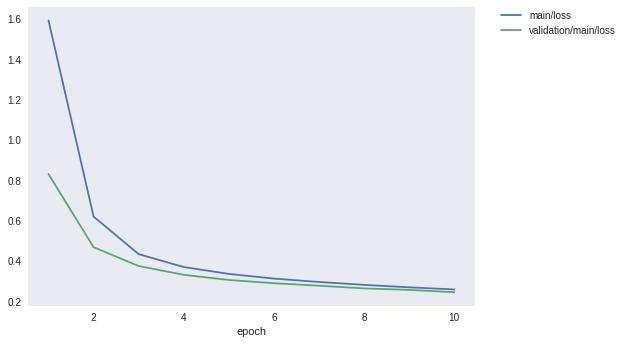

In [9]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

How about the accuracy? 

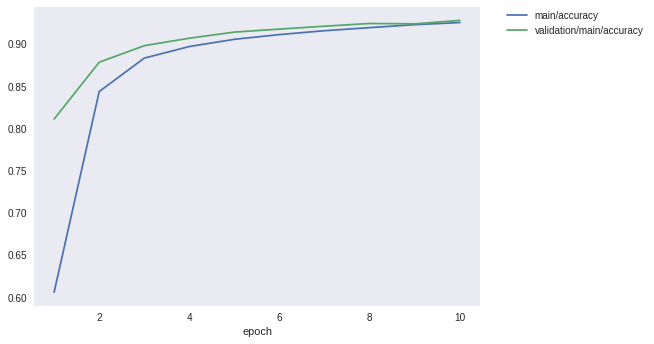

In [10]:
Image(filename='mnist_result/accuracy.png')

Furthermore, let's visualize the computational graph output by `dump_graph` of `extensions` using `Graphviz`. 

In [13]:
!apt-get install graphviz -y
!dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3 libgraphite2-3
  libgvc6 libgvpr2 libharfbuzz0b libice6 libjbig0 libltdl7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4 libpixman-1-0 libsm6
  libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0 libxcb-shm0
  libxext6 libxmu6 libxpm4 libxt6 x11-common
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgraphite2-3 libgvc6 libgvpr2 libharfbuzz0b libice6 libjbig0 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libsm6 libthai-data libthai0 libtiff5 libwebp6 libxaw7
  libxcb-render0 libxcb-shm0 libxext6 libxmu6 libxpm4 libxt6 x11-common
0 upgraded, 32 newly installed, 0 to remove and 1 n

Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../08-libtiff5_4.0.8-5_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../09-libwebp6_0.6.0-3_amd64.deb ...
Unpacking libwebp6:amd64 (0.6.0-3) ...
Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../10-libxpm4_1%3a3.5.12-1_amd64.deb ...
Unpacking libxpm4:amd64 (1:3.5.12-1) ...
Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../11-libgd3_2.2.5-3_amd64.deb ...
Unpacking libgd3:amd64 (2.2.5-3) ...
Selecting previously unselected package libpixman-1-0:amd64.
Preparing to unpack .../12-libpixman-1-0_0.34.0-1_amd64.deb ...
Unpacking libpixman-1-0:amd64 (0.34.0-1) ...
Selecting previously unselected package libxcb-render0:amd64.
Preparing to unpack .../13-libxcb-render0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-render0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected pack

Setting up graphviz (2.38.0-16ubuntu2) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...


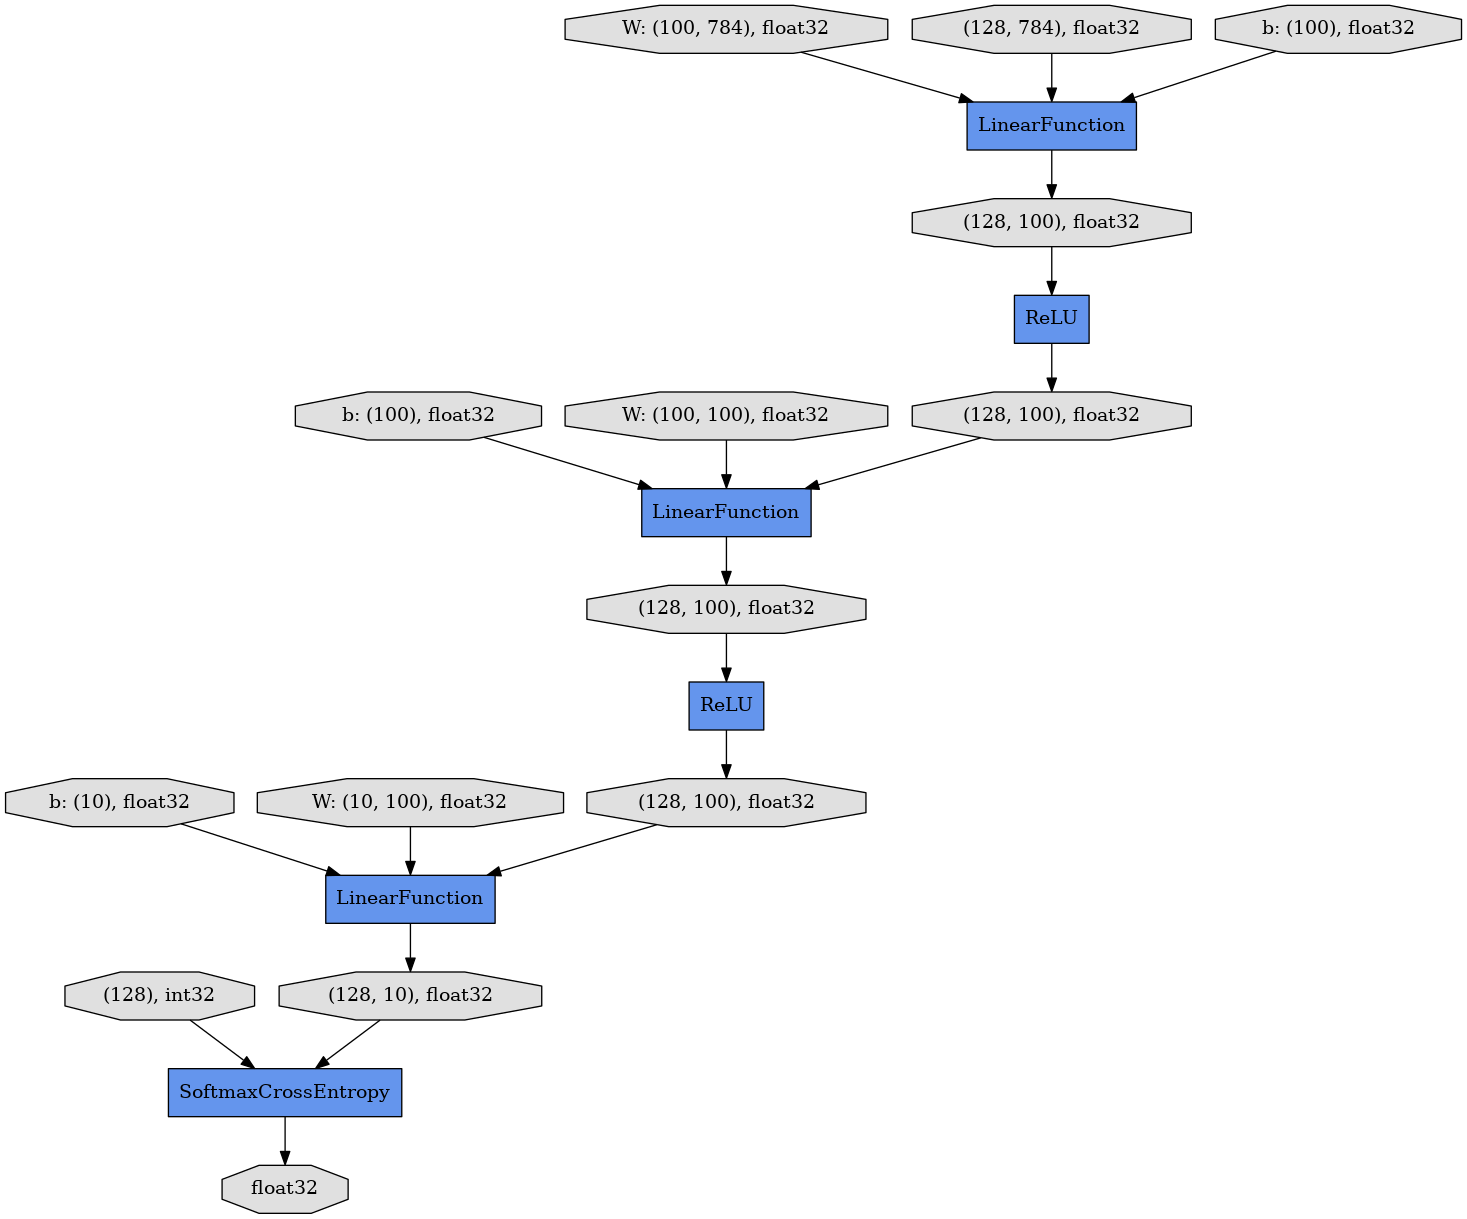

In [14]:
Image(filename='mnist_result/cg.png')

From the top to the bottom, you can track the data flow of the computations, how data and parameters are passed to what type of `Function` and the calculated loss is output. 

## 8. Evaluate a pre-trained model

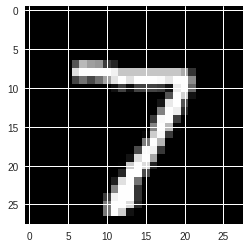

label: 7
predicted_label: 7


In [15]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)

%matplotlib inline
import matplotlib.pyplot as plt

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

if gpu_id >= 0:
    model.to_gpu(gpu_id)
    x = to_gpu(x[None, ...])
    y = model(x)
    y = to_cpu(y.data)
else:    
    x = x[None, ...]
    y = model(x)
    y = y.data

print('predicted_label:', y.argmax(axis=1)[0])

It successfully executed !!